<a href="https://colab.research.google.com/github/jnsbrdbr/final_thesis/blob/main/7_2_GanUnsmote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.8.0


In [2]:
import keras
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
import keras.backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 256 kB 4.1 MB/s 


In [5]:
with pd.HDFStore('/content/drive/MyDrive/1000/TUnsmote_result',  mode='r') as newstore:
    result = newstore.select('result')

In [6]:
#final data
print(result)

            0         1         2             3             4         5  \
0   -1.715972 -3.099936 -0.041249  6.644563e-15 -4.921070e-14  0.077295   
1   -1.715972 -3.099936 -0.041249  3.045569e-14 -7.800524e-14  0.077295   
2   -1.715972 -3.099936 -0.041249 -1.496646e-13  2.954769e-13  0.077295   
3   -1.715972 -3.099936 -0.041249  2.266833e-14 -1.476736e-13  0.077295   
4   -1.715972 -3.099936 -0.041249  4.970204e-15 -3.353379e-14  0.077295   
..        ...       ...       ...           ...           ...       ...   
995 -2.114893 -4.572474 -0.754679 -6.555974e-14 -8.861794e-13  8.797502   
996 -2.114893 -4.572474 -0.754679 -6.514700e-14 -8.864474e-13  8.797502   
997 -2.114893 -4.572474 -0.754679 -6.524139e-14 -8.861148e-13  8.797502   
998 -2.114893 -4.572474 -0.754679 -6.386130e-14 -8.857102e-13  8.797502   
999 -2.114893 -4.572474 -0.754679 -6.629200e-14 -8.862672e-13  8.797502   

            6         7             8             9  ...             1  \
0    1.691428  3.341114 -

In [7]:
#divide data in to data_label and non_data label

import copy
result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel
y=result.label

In [8]:
#splitting data in to test and train...

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y ,random_state=42,test_size=0.3)#

In [9]:
print('shape of x_train is:',X_train.shape)
print('shape of x_test is:',X_test.shape)

shape of x_train is: (700, 70)
shape of x_test is: (300, 70)


In [10]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [11]:
make_latent_samples(1, 100) # generates one sample

array([[-0.27505305, -0.27982449,  1.91941817,  1.42267057,  1.22771675,
         2.0003184 , -0.31980377, -1.60777904,  0.21114484, -1.41362061,
         1.2425782 , -1.2924744 , -0.25986534,  1.3911619 , -0.33621047,
         0.11846988, -0.32541221,  1.29158215,  1.87883679, -1.56292483,
        -1.66091912,  0.3922683 , -0.82848804,  0.10857984, -0.86924361,
        -0.21938866,  1.01533006, -1.37488603, -2.25627041, -1.82127767,
         1.91486301,  0.11619433, -2.00820304, -0.23686143, -1.31610396,
        -0.93817384,  0.65484384,  1.32360811,  1.75691389, -0.57040343,
        -1.06677889,  0.05773368,  0.51422233, -0.90390583, -0.42118635,
         1.17299389,  0.24591989, -0.28293853,  0.74131307,  0.05408056,
        -1.4576113 , -0.23630594,  0.5543312 ,  0.32946848, -0.26492815,
         0.2731723 , -1.49079283, -1.19097918,  0.16651259,  0.98792024,
        -0.80968229, -0.90615497, -0.98510311, -1.31523464,  0.90559126,
        -0.5834124 ,  0.41459076, -0.19153228,  1.2

In [12]:
generator = Sequential([
    Dense(128, input_shape=(100,)),
    LeakyReLU(alpha=0.2),
    BatchNormalization(momentum=0.7),

    #Dense(100),
    #LeakyReLU(alpha=0.2),
    #BatchNormalization(momentum=0.7),

    #Dense(1024),
    #LeakyReLU(alpha=0.2),
    #BatchNormalization(momentum=0.7),

    #Dense(2048),
    #LeakyReLU(alpha=0.2),
    #BatchNormalization(momentum=0.7),

    Dense(70),
    Activation('tanh')
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 70)                9030      
                                                                 
 activation (Activation)     (None, 70)                0         
                                                                 
Total params: 22,470
Trainable params: 22,214
Non-trainable params: 256
___________________________________________________

In [13]:
discriminator = Sequential([
    Dense(64, input_shape=(70,)),
    LeakyReLU(alpha=0.2),
    #BatchNormalization(momentum=0.7),

    Dense(32),
    LeakyReLU(alpha=0.2),
    #BatchNormalization(momentum=0.7),

    #Dense(128),
    #LeakyReLU(alpha=0.2),
    #BatchNormalization(momentum=0.7),
    #Dense(64),
    #LeakyReLU(alpha=0.2),
    #BatchNormalization(momentum=0.7),

    #Dense(32),
    #LeakyReLU(alpha=0.2),
    #BatchNormalization(momentum=0.7),

    #Dense(16),
    #LeakyReLU(alpha=0.2),
    #BatchNormalization(momentum=0.7),

    Dense(1),
    Activation('sigmoid')
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                4544      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 6,657
Trainable params: 6,657
Non-train

In [14]:
# maintain the same shared weights with the generator and the discriminator.
gan = Sequential([
    generator,
    discriminator
])

gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 70)                22470     
                                                                 
 discriminator (Sequential)  (None, 1)                 6657      
                                                                 
Total params: 29,127
Trainable params: 28,871
Non-trainable params: 256
_________________________________________________________________


In [15]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [16]:
make_trainable(discriminator, False)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                4544      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 6,657
Trainable params: 0
Non-trainable

In [17]:
make_trainable(discriminator, True)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                4544      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 6,657
Trainable params: 6,657
Non-train

In [18]:
def make_simple_GAN(sample_size, 
                    g_hidden_size_1,
                    g_hidden_size_2,
                    g_hidden_size_3,
                    g_hidden_size_4,
                    d_hidden_size_1,
                    d_hidden_size_2, 
                    d_hidden_size_3,
                    d_hidden_size_4,
                    d_hidden_size_5,
                    d_hidden_size_6,
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size_1, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        BatchNormalization(momentum=0.7),

        #Dense(g_hidden_size_2),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.7),

        #Dense(g_hidden_size_3),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.7),

        #Dense(g_hidden_size_4),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.7),

        Dense(70),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size_1, input_shape=(70,)),
        LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.7),

        Dense(d_hidden_size_2),
        LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.7),

        #Dense(d_hidden_size_3),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.7),

        #Dense(d_hidden_size_4),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.7),

        #Dense(d_hidden_size_5),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.7),

        #Dense(d_hidden_size_6),
        #LeakyReLU(alpha=leaky_alpha),
        #BatchNormalization(momentum=0.7),

        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator 

In [19]:
from sklearn import preprocessing
def preprocess(x):
   x = preprocessing.scale(x)
   return x

In [20]:
X_train_real = np.array(preprocess(X_train))
X_test_real  = np.array(preprocess(X_test))

In [21]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [22]:
y_real_10, y_fake_10 = make_labels(10)

y_real_10, y_fake_10

(array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [23]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size_1 = 128
g_hidden_size_2 = 0
g_hidden_size_3 = 0
g_hidden_size_4 = 0
d_hidden_size_1 = 64
d_hidden_size_2 = 32
d_hidden_size_3 = 0
d_hidden_size_4 = 0
d_hidden_size_5 = 0
d_hidden_size_6 = 0
leaky_alpha     = 0.2
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.0001   # learning rate for the discriminator
epochs          = 100
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1


In [24]:
## labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size_1, 
    g_hidden_size_2,
    g_hidden_size_3,
    g_hidden_size_4, 
    d_hidden_size_1, 
    d_hidden_size_2,
    d_hidden_size_3,
    d_hidden_size_4,
    d_hidden_size_5,
    d_hidden_size_6,
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)


losses = []
losses1 = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
   # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))

    d_acc_real = discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
    d_acc_fake = discriminator.train_on_batch(X_batch_fake, y_train_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)

    #losses1.append(( d_acc))
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f} Discriminator acc:{:>6.4f}".format(
        e+1, epochs, d_loss, g_loss,d_acc)) #Discriminator acc: {:>6.4f}:,d_acc

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch:   1/100 Discriminator Loss: 1.6708 Generator Loss: 0.7653 Discriminator acc:0.7448
Epoch:   2/100 Discriminator Loss: 1.5684 Generator Loss: 0.7602 Discriminator acc:0.7233
Epoch:   3/100 Discriminator Loss: 1.5621 Generator Loss: 0.6897 Discriminator acc:0.7041
Epoch:   4/100 Discriminator Loss: 1.4927 Generator Loss: 0.6469 Discriminator acc:0.7271
Epoch:   5/100 Discriminator Loss: 1.5624 Generator Loss: 0.5664 Discriminator acc:0.7287
Epoch:   6/100 Discriminator Loss: 1.4017 Generator Loss: 0.5965 Discriminator acc:0.7282
Epoch:   7/100 Discriminator Loss: 1.3542 Generator Loss: 0.5871 Discriminator acc:0.7324
Epoch:   8/100 Discriminator Loss: 1.5264 Generator Loss: 0.5223 Discriminator acc:0.7335
Epoch:   9/100 Discriminator Loss: 1.4588 Generator Loss: 0.5231 Discriminator acc:0.7562
Epoch:  10/100 Discriminator Loss: 1.4802 Generator Loss: 0.4839 Discriminator acc:0.7546
Epoch:  11/100 Discriminator Loss: 1.4975 Generator Loss: 0.4840 Discriminator acc:0.7483
Epoch:  12

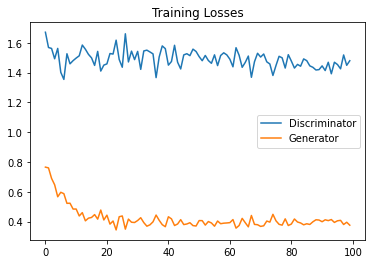

In [25]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

In [26]:
rr = discriminator.predict_on_batch(X_test_real)

In [27]:
import keras
#import keras_metrics

r = tf.keras.metrics.Recall()#thresholds=rr.min())
r.update_state(y_test,rr )
r.result().numpy()


0.996633

In [28]:
p=tf.keras.metrics.Precision()#thresholds=rr.min())
p.update_state(y_test,rr )
p.result().numpy()

0.9899666

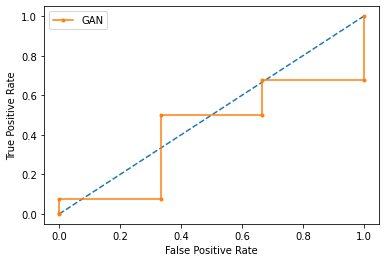


 Logistic ROC AUC 0.418


In [29]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve



yhat = discriminator.predict_on_batch(X_test_real)
pos_probs = yhat[:, :]
pyplot.plot([0, 1], [0, 1], linestyle='--')
fpr, tpr, _ = roc_curve(y_test, pos_probs)
pyplot.plot(fpr, tpr, marker='.', label='GAN')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

roc_auc = roc_auc_score(y_test, pos_probs)
print('\n','Logistic ROC AUC %.3f' % roc_auc)